# Continuidade Operacional: Projeto Preditivo de Manutenção de Máquinas

<img src="https://proconcept.com.br/wp-content/uploads/2022/06/tipos-manutencao-preditiva-768x432.jpg.webp" height="200" width="400">

**By:** [Ana Pinheiro](https://www.linkedin.com/in/ana-pego/)

O projeto visa prever e prevenir falhas em máquinas utilizando técnicas de aprendizado de máquina. O objetivo é reduzir custos e tempo de inatividade, garantindo operações mais eficientes e sustentáveis.

<font size="5"><a id="sumario"><bold>Summary</bold></a></font>
***
>1. [Imports](#ses1)
>2. [Informações conjunto de dados](#ses2)
>3. [Análise exploratória](#ses3)
>4. [Pré-processamento dos dados](#ses4)
>5. [Seleção das variáveis](#ses5)
>6. [Modelo XGBoost](#ses6)
>7. [Avaliando o modelo](#ses7)


<h2><a id="ses1">Imports</a></h2>

Importanção das bibliotecas necessárias para o desenvolvimento do projeto.

[Voltar](#sumario)

In [205]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import warnings
from sklearn import metrics
from IPython.display import display
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [206]:
# Para ignorar mensagens de alertas 
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

# Saída das tabelas
np.set_printoptions(threshold=None, precision=2)

<h2><a id="ses2">Informações do conjunto de dados</a></h2>

[Voltar](#sumario)

O conjunto de dados para o desenvolvimento desse projeto é o [AI4I 2020 Predictive Maintenance Dataset - UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset). São um conjunto de dados sintético que reflete a manutenção preditiva real encontrada na indústria.

O conjunto de dados consiste em 10 mil linhas e 10 colunas:

* UID: identificador único;

* ProductID: identificador único de produtpr consistindo em uma letra L, M ou H para baixa (50% de todos os produtos), média (30%) e alta (20%) como variantes de qualidade do produto;

* Type: tipo do produto, **L** qualidade baixa, **M** qualidade média e **H** qualidade alta;

* Air temperature [K]: temperatura do ar medida em Kelvin;

* Process temperature [K]:  temperatura do processo, que é a temperatura associada ao processo de fabricação ou operação do produto;

* Rotational speed [rpm]: velocidade de rotação, medida em rotações por minuto (RPM);

* Torque [Nm]: força rotacional medido em Newton metros (Nm);

* Tool wear [min]: tempo de desgaste medido em minuto;

* Target: apresneta falha ou não;

* Failure Type: Tipo da falha;

<h2><a id="ses3">Análise Exploratória</a></h2>

Nessa sessão, aplicaremos técnicas de análise exploratória para compreender os dados, identificar padrões e possíveis anomalias nos dados.  Isso nos ajudará a obter insights iniciais sobre o conjunto de dados e a entender melhor suas características.

[Voltar](#sumario)

In [208]:
# load data
dataset = pd.read_csv("./Data/predictive_maintenance.csv")
print('Dimensão dataset:', dataset.shape, '\n')
dataset.head()

Dimensão dataset: (10000, 10) 



,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [160]:
# checking the type of columns and null values
null_df = dataset.isnull().sum() * 100/len(dataset)

info_df = pd.DataFrame({'qtd_missing': dataset.isnull().sum(),
                       'percent_missing': null_df,
                       'dtype': dataset.dtypes}
                      ).reset_index().rename(columns={'index': 'column'})
info_df

,column,qtd_missing,percent_missing,dtype
0,UDI,0,0.0,int64
1,Product ID,0,0.0,object
2,Type,0,0.0,object
3,Air temperature [K],0,0.0,float64
4,Process temperature [K],0,0.0,float64
5,Rotational speed [rpm],0,0.0,int64
6,Torque [Nm],0,0.0,float64
7,Tool wear [min],0,0.0,int64
8,Target,0,0.0,int64
9,Failure Type,0,0.0,object


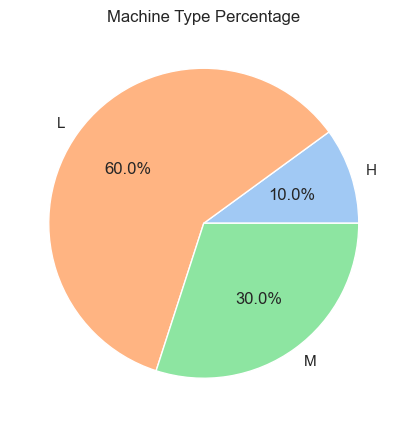

In [161]:
qtd_product_type = dataset[['Product ID','Type']].groupby('Type').count().reset_index()

sns.set(rc={'figure.figsize':(5,6)})
colors = sns.color_palette('pastel')
g = plt.pie(x=qtd_product_type['Product ID'],
    labels=qtd_product_type['Type'],colors = colors, autopct='%.1f%%')

plt.title("Machine Type Percentage")
plt.show()

<span style="color: #cca002">Obs:</span> No gráfico **Machine Type Percentage** observa-se que o tipo de máquina mais frequente no conjunto de dados é o tipo ***L***, seguido por ***M*** e ***H***. Lembrando que as letras representam a qualidade dos produtos, issi siganifica que 60% dos produtos correspondem aos produtos de baixa qualidade.

Analyzing the main machine failures:

Number of failed and non-failed machines:
0 (No Failure): 1 (Failure):


,Target,Product ID
0,0,9661
1,1,339



Frequency of failure type:


,index,Failure Type,Target
0,1,No Failure,9652
1,0,Heat Dissipation Failure,112
2,3,Power Failure,95
3,2,Overstrain Failure,78
4,5,Tool Wear Failure,45
5,4,Random Failures,18


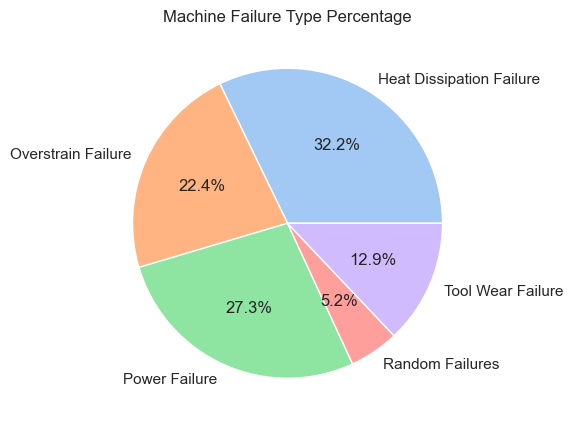

In [211]:
print('Analyzing the main machine failures:\n')

print('Number of failed and non-failed machines:\n0 (No Failure): 1 (Failure):')
target = dataset[['Product ID', 'Target']].groupby('Target', as_index=False).count()
display(target)


print('\nFrequency of failure type:')
type_failure = dataset[['Failure Type', 'Target']].groupby('Failure Type', as_index=False).count().sort_values('Target', ascending=False).reset_index()
display(type_failure)

qtd_failure = dataset[['Target','Failure Type']].loc[(dataset['Failure Type'] != 'No Failure')
                                                   ].groupby('Failure Type').count().reset_index()

sns.set(rc={'figure.figsize':(5,6)})
colors = sns.color_palette('pastel')
g = plt.pie(x=qtd_failure['Target'],
    labels=qtd_failure['Failure Type'],colors = colors, autopct='%.1f%%')

plt.title("Machine Failure Type Percentage")

plt.show()

<span style="color: #cca002">Obs:</span> No gráfico **Machine Failure Type Percentage**, não foram incluídas as máquinas que não apresentaram falha, uma vez que representam 96% do conjunto de dados. O objetivo do gráfico é analisar as falhas mais comum entre as máquinas. 

Observa-se que o tipo de falha mais comum é relacionados à ***dissipação de calor***, enquanto a menos comum é classificado como ***aleatótio***. Normalmente, as falhas são caracterizadas por algum tipo específicos, o que pode fornecer insights valiosos sobre os problemas enfrentados pelas máquinas.

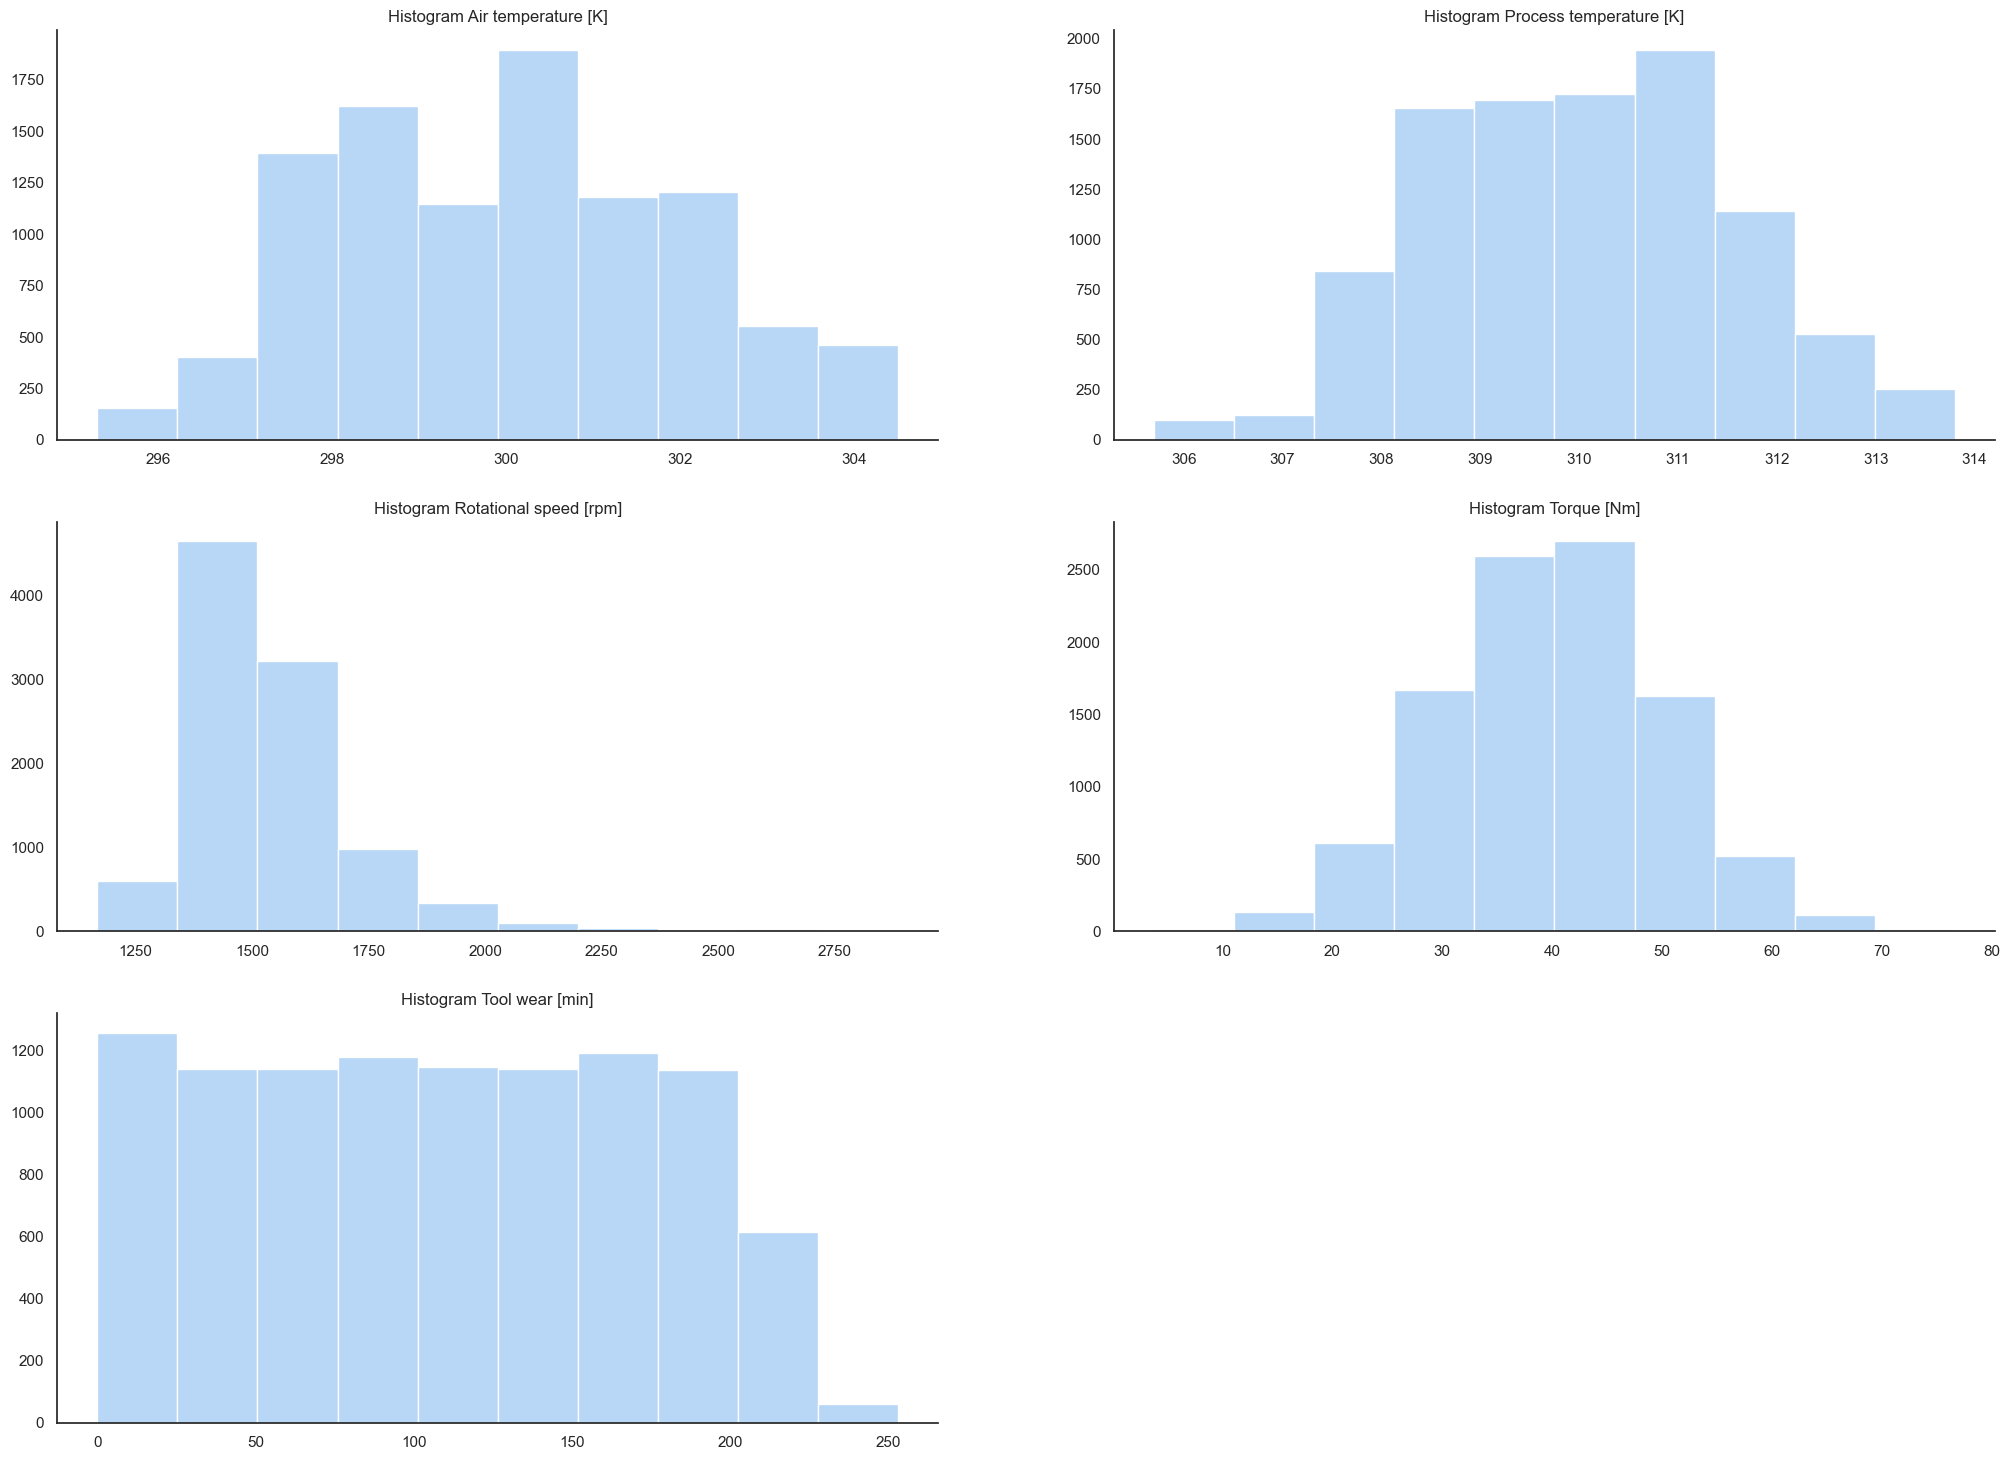

In [163]:
columns_number = dataset.drop(columns=['Target', 'UDI']).select_dtypes(exclude=['object']).columns

plt.figure(figsize=(25, 50))
sns.set_style("white")
col_count = 1

for col in columns_number[:10]:
    plt.subplot(8, 2, col_count)
    sns.histplot(x=dataset[col], kde=False, bins=10, color='#a1c9f4')
    
    plt.title(f'Histogram {col}')
    plt.xlabel('')
    plt.ylabel('')

    col_count += 1

sns.despine()

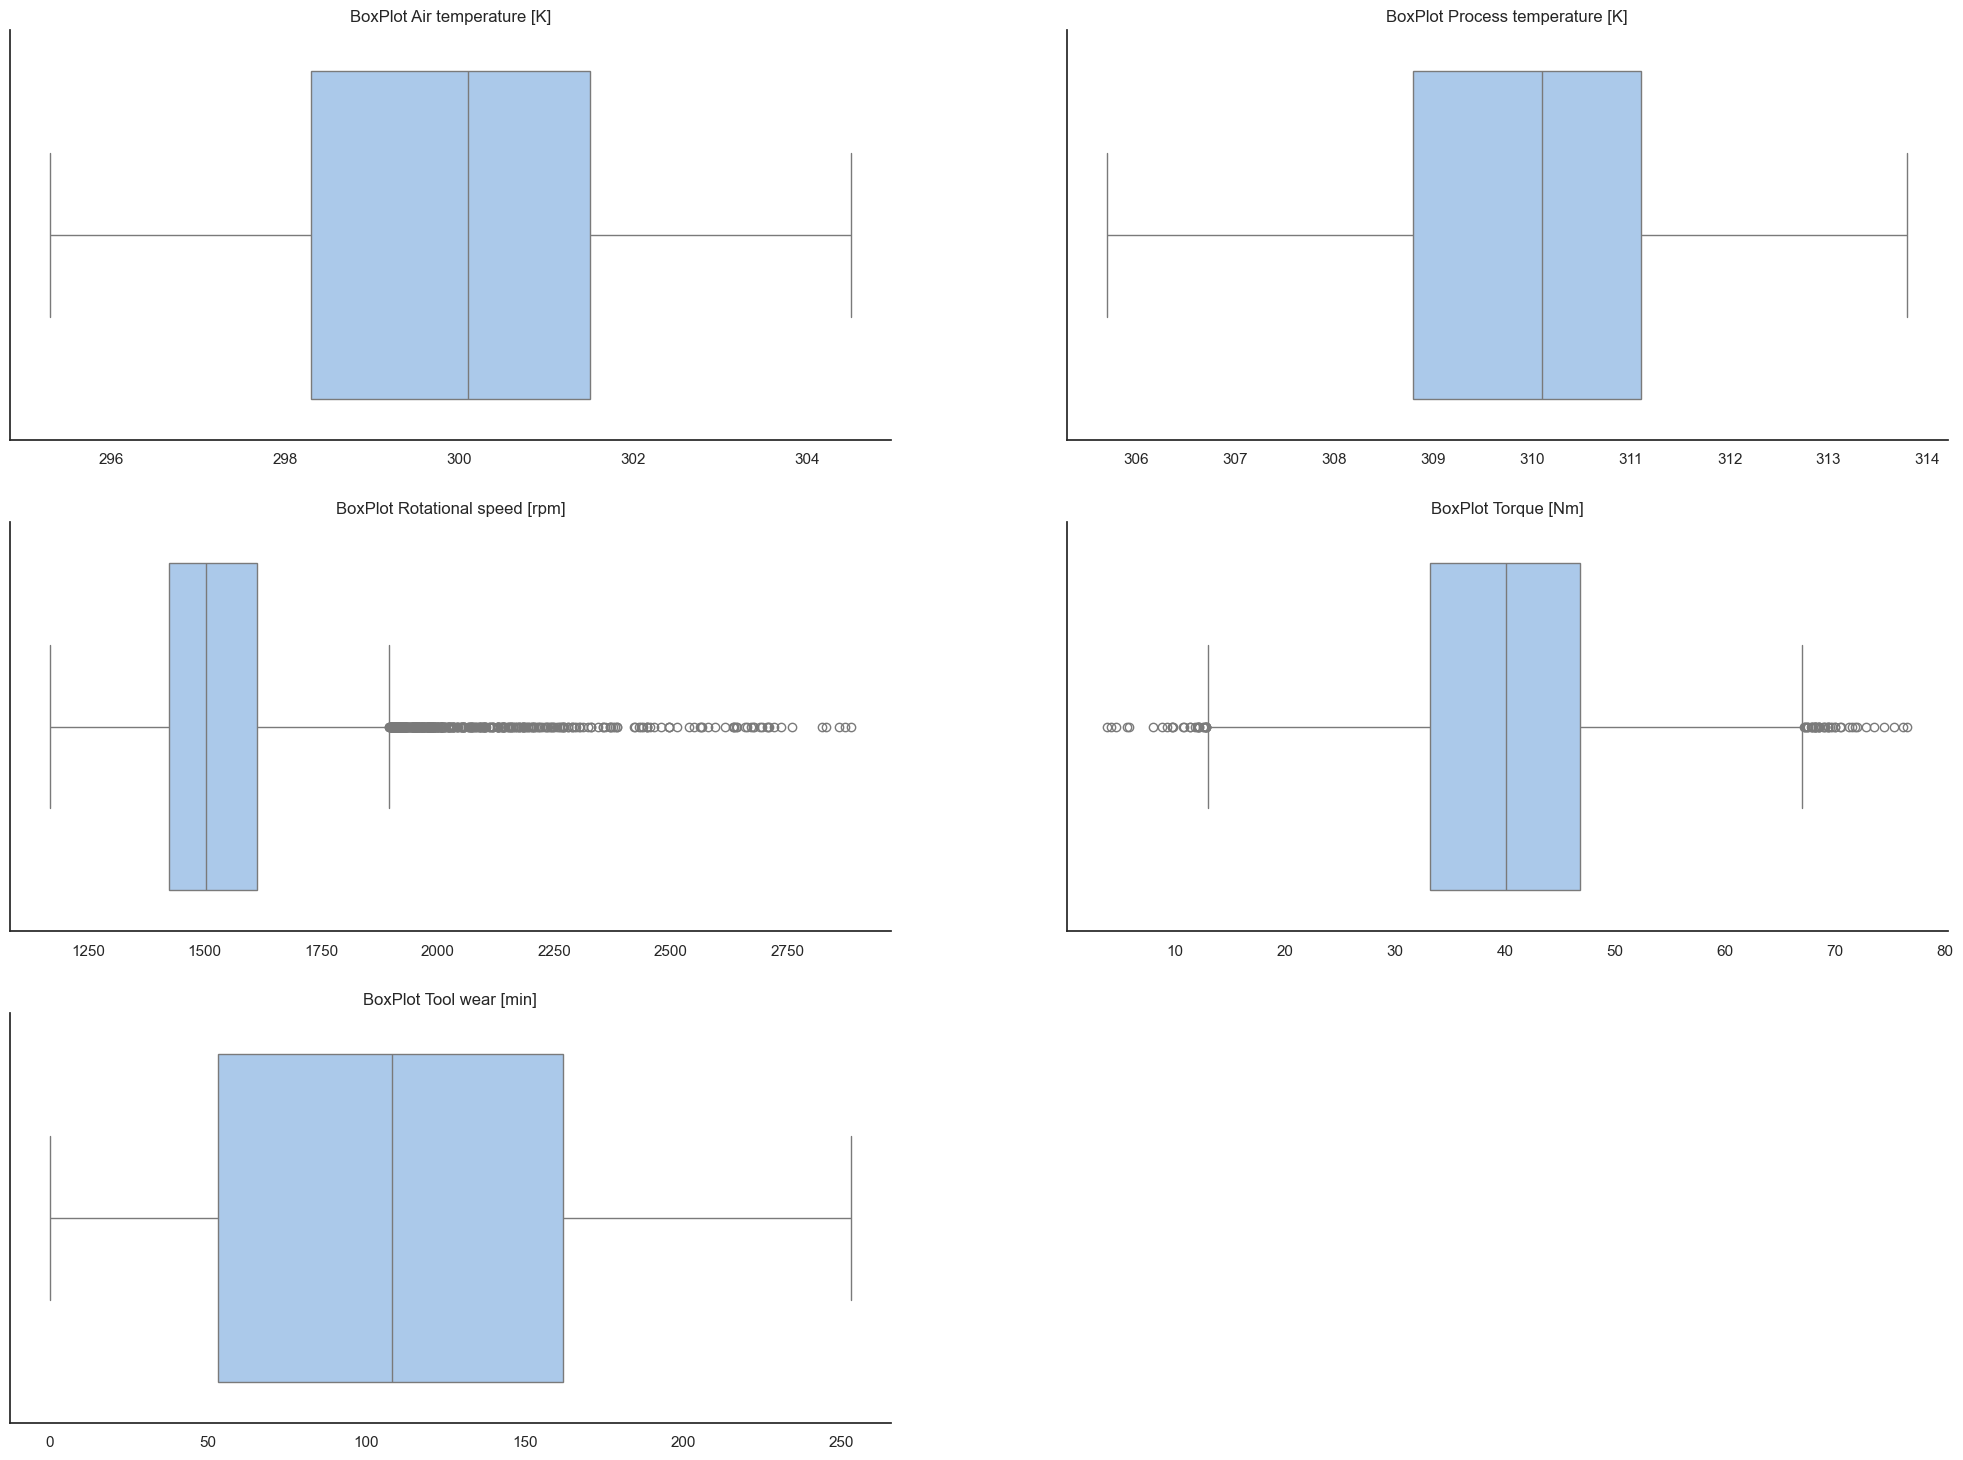

In [164]:
columns_number = dataset.drop(columns=['Target', 'UDI']).select_dtypes(exclude=['object']).columns

plt.figure(figsize=(25, 50))
sns.set_style("white")
col_count = 1

for col in columns_number[:10]:
    plt.subplot(8, 2, col_count)
    sns.boxplot(x=dataset[col], color='#a1c9f4')
    
    plt.title(f'BoxPlot {col}')
    plt.xlabel('')
    plt.ylabel('')

    col_count += 1

sns.despine()
plt.show()

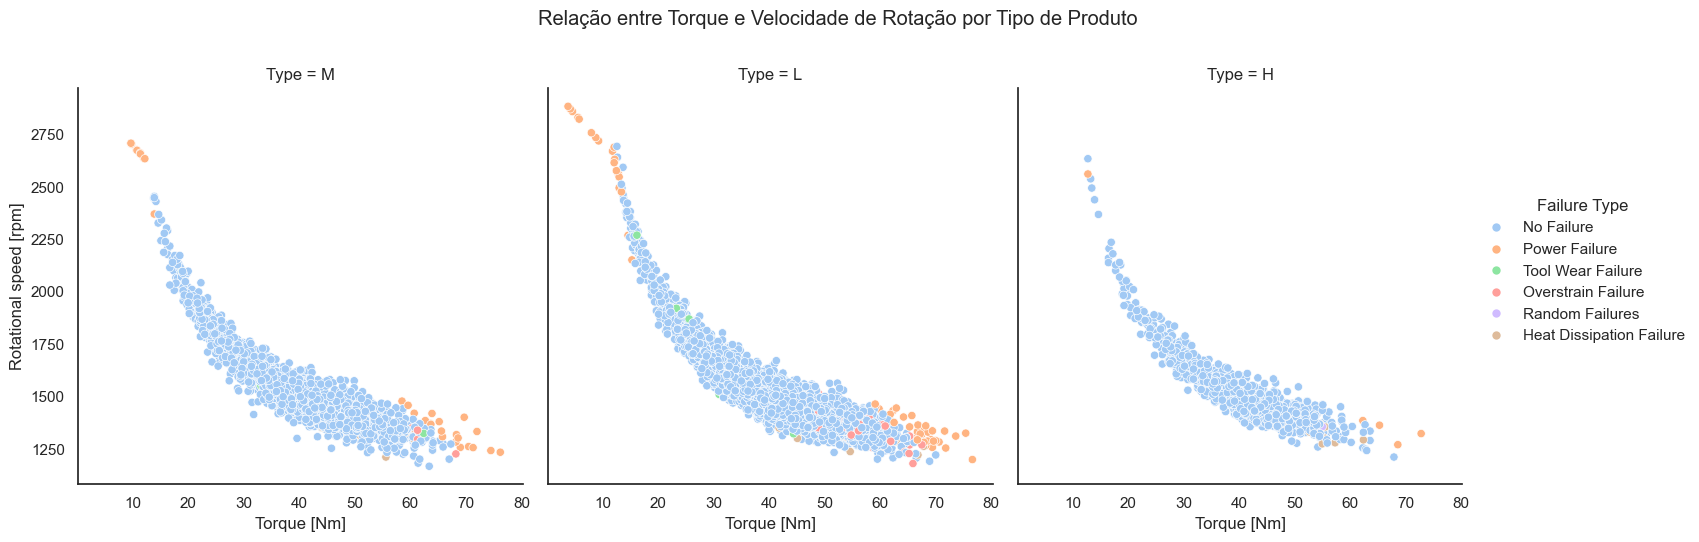

In [165]:
sns.set_style("white")
sns.relplot(data=dataset, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type",col="Type",palette='pastel');
plt.suptitle("Relação entre Torque e Velocidade de Rotação por Tipo de Produto", y=1.08)
sns.despine()
plt.show()

<h2><a id="ses4">Pré-Processamento dos Dados</a></h2>

[Voltar](#sumario)

In [166]:
# removing characters not relevant columns name
def rename_coll(x:pd.DataFrame) -> pd.DataFrame: 
    x.columns=x.columns.str.replace(r'\s*\[.*?\]\s*', '', regex=True).str.title().str.replace(' ', '')
    
rename_coll(dataset)

In [167]:
# the ProductId column has the product type in its values, which is not necessary because in dataset it 
# has a column with product type

# remove type
dataset['ProductId'] = dataset['ProductId'].apply(lambda x: x[1:])
dataset['ProductId'] = pd.to_numeric(dataset['ProductId'])

In [168]:
# remove column UDI
dataset.drop(columns=['Udi'], axis=1, inplace=True)

####  Enconding

In [169]:
# enconding in variable categoria ordering
code_type = {'L': 0, 'M': 1,  'H': 2}

dataset['Type'] = dataset['Type'].map(code_type)

# enconding in variable categoria not ordering
code_failure = {'No Failure': 0,'Heat Dissipation Failure': 1,'Power Failure': 2,'Overstrain Failure': 3,
                'Tool Wear Failure': 4,'Random Failures': 5 }

dataset['FailureType'] = dataset['FailureType'].map(code_failure)

In [170]:
print('Correlation')
dataset.corr().style.background_gradient(cmap='coolwarm')

Correlation


,ProductId,Type,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,Target,FailureType
ProductId,1.000000,-0.752264,0.023137,0.063626,0.003413,0.000427,0.005869,0.026477,0.033809
Type,-0.752264,1.000000,-0.015176,-0.012101,-0.003979,-0.003097,-0.007255,-0.036715,-0.032077
AirTemperature,0.023137,-0.015176,1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556,0.040470
ProcessTemperature,0.063626,-0.012101,0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946,0.026149
RotationalSpeed,0.003413,-0.003979,0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188,-0.025110
Torque,0.000427,-0.003097,-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321,0.142830
ToolWear,0.005869,-0.007255,0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448,0.140449
Target,0.026477,-0.036715,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000,0.793655
FailureType,0.033809,-0.032077,0.040470,0.026149,-0.025110,0.142830,0.140449,0.793655,1.000000


<h2><a id="ses5">Seleção das variáveis</a></h2>

[Voltar](#sumario)

In [171]:
# select variables
dataset = dataset.drop(columns=['ProductId'])

In [186]:
# variable target
target = dataset[['Target']]
subset = dataset.drop(columns = ['Target', 'FailureType'])

In [187]:
# train and test
X_train, X_test, y_train, y_test = train_test_split(subset,target,  test_size = 0.30, random_state=0)

In [188]:
print(f'Train data: {X_train.shape[0]}')
print(f'Test data: {X_test.shape[0]}')

Train data: 7000
Test data: 3000


<h2><a id="ses6">Modelo XGBoost</a></h2>

[Voltar](#sumario)

In [189]:
# model
xgb = XGBClassifier(n_estimators = 200,  # número de árvores 
                    max_depth = 6,  # profundidade máxina da árvore
                    learning_rate = 0.01, # controla o peso de novas árvores adicionadas ao modelo
                    subsample = 0.8,
                     objective= 'binary:logistic', # retorna a probabilidade prevista de cada ponto de dados pertencente a cada classe
                    random_state=0)

In [190]:
# training model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [191]:
# predict data
y_pred = xgb.predict(X_test)

<h2><a id="ses7">Avaliando o modelo</a></h2>

[Voltar](#sumario)

In [192]:
# values confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# df
confusion_df = pd.DataFrame(
    {
        "Predicted No": [f"TN = {tn}", f"FN = {fn}"],
        "Predicted Yes": [f"FP = {fp}", f"TP = {tp}"]
    },
    index=["Actual No", "Actual Yes"]
)

confusion_df

,Predicted No,Predicted Yes
Actual No,TN = 2893,FP = 8
Actual Yes,FN = 43,TP = 56


In [193]:
# accurary model
print(f'Accurary Model: {round(accuracy_score(y_test, y_pred)*100,3)}%')

Accurary Model: 98.3%


In [194]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2901
           1       0.88      0.57      0.69        99

    accuracy                           0.98      3000
   macro avg       0.93      0.78      0.84      3000
weighted avg       0.98      0.98      0.98      3000



In [195]:
# performance on training data
y_pred_train = xgb.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

#  performance on test data
y_pred_test = xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Performance on training data:", train_accuracy)
print("Performance on test data:", test_accuracy)

Performance on training data: 0.9911428571428571
Performance on test data: 0.983


In [202]:
# feature importance -  feature most frequently
importance = xgb.get_booster().get_score(importance_type='weight')

# feature name and the importance
features = [x[0] for x in sorted_importance]
importances = [x[1] for x in sorted_importance]

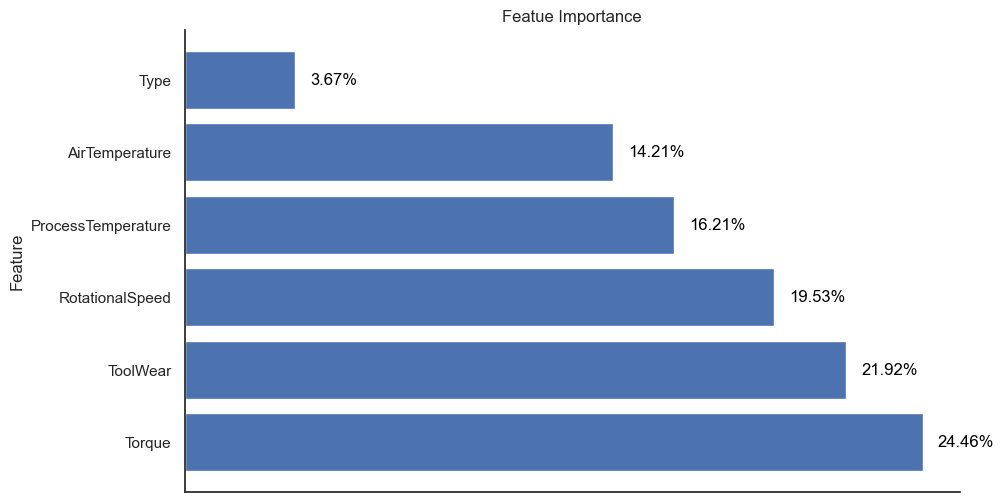

In [204]:
# graph
importances_percentage = [(imp / sum(importances)) * 100 for imp in importances]

plt.figure(figsize=(10, 6))
sns.set_style("white")
bars = plt.barh(features, importances_percentage)

for bar, importance in zip(bars, importances_percentage):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{importance:.2f}%', 
             va='center', ha='left', color='black')

plt.gca().axes.get_xaxis().set_visible(False)
plt.ylabel('Feature')
plt.title('Featue Importance')
sns.despine()
plt.show()